<a href="https://colab.research.google.com/github/fares37665/optimisation_tp/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import numpy as np

def load_breastcancer(filename):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'wdbc_M1_B0.data'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29
    """

    data = np.loadtxt(filename, delimiter=',')

    # la colonne 0 ne nous interesse pas ici
    y = data[:, 1] * 2 - 1
    X = data[:, 2:]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y



## 1. Données

In [0]:
#from breastcancerutils import *

# X est un dataset de caractéristiques
# y est un vecteur de classe tel que si y[i]=1,la tumeur est maligne, et si y[i]=-1, la tumeur est bénigne.
X, y = load_breastcancer('wdbcM1B0.data.txt')

In [0]:
print(X.shape)

(569, 30)


## 2. Méthode du sous-gradient

### 2.1

Let $\xi*$such that $\xi*_i=max(0,1-y_i(x_i^Tv+a))$

Let $f(a,v,\xi)=\frac{1}{2}\sum_{j=1}^mv_j^2+c\sum_{i=1}^n\xi_i$
On one hand,
$f(a,v,\xi*)=\frac{1}{2}\sum_{j=1}^mv_j^2+c\sum_{i=1}^nmax(0,1-y_i(x_i^Tv+a))$

$f(a,v,\xi*)\geq\min_{\xi_i\geq0, \xi_i\geq1-y_i(x_i^Tv+a)}f(a,v,\xi)$

Thus,by applying to the min on the left hand side:
$\min_{\xi_i\geq0, \xi_i\geq1-y_i(x_i^Tv+a)}f(a,v,\xi)\leq \min_{a,v}f(a,v,\xi*)$

On the other hand,
$\forall \xi_i, \xi_i\geq0 , \xi_i\geq1-y_i(x_i^Tv+a) \rightarrow \xi_i\geq \mathrm{max}(0,1-y_i(x_i^Tv+a))$

Thus, under contraints on $\xi$,
$f(a,v,\xi)\geq f(a,v,\xi*)$

Thus,
$\min_{\xi_i\geq0, \xi_i\leq1-y_i(x_i^Tv+a)}f(a,v,\xi)\geq \min_{a,v}f(a,v,\xi*)$


Which shows the equality between the 2 minimas.





### 2.2

We verify graphicaly the result stated in the teaching document.

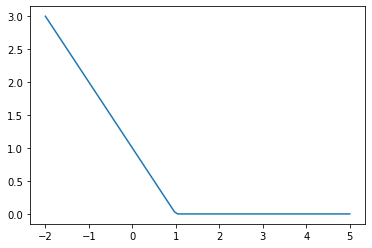

In [0]:
u = np.linspace(-2, 5, 100)
plt.plot(u, ([1-u > 0]*(1-u)).T)

### 2.3

$\begin{align*}\\
f(v,a) &= \frac{1}{2} \sum_{j=1}^m v_j^2 + c \sum_{i=1}^{m}\max(0,1-y_i(x_i^Tv + a))\\
&=  N(v,a) + c \sum_{i=1}^{m} \max(0, 1-M(v,a))\\
&=  N(v,a) + c H(M(v,a))\\
\end{align*}$

With $M$ obviously linear, and $N$ and $H$ two functions. 

Thus, using 2.4.2 formula,

$\begin{align*}\\
\partial f(v,a) &= \partial (N + cH \circ M)(v, a)\\
&= \partial N + c \partial(H \circ M)(v,a) \\
&= \partial N(v,a)  + c M^T \partial H(M(v,a)) 
\end{align*}$

We have $N(v,a) = \frac{1}{2} \|v\|^2 $

Thus $\partial N(v,a) = \{ (\nabla N(v,a), 0) \} = \{(v, 0)\}$

$H(z)=\sum_imax(0,1-z_i)$

$\partial H(z)=\partial h(z_1)\times...\times\partial h(z_n)$

### 2.4

In [0]:
n = X.shape[0]
m = X.shape[1]
M = np.zeros((n, m+1))
for i in range(n):
    M[i, :-1] = y[i]*X[i,:].T
    M[i, -1] = y[i]

def func_f(v, a, c=1):
    h = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        h[i] = max(0, 1 - y[i]*(X[i,:].T.dot(v) + a))
    output = .5 * np.sum(v**2) + c * np.sum(h)
    return output

def dronde_f(v, a, c=1):
    #h = np.zeros(X.shape[0])
    #for i in range(X.shape[0]):
    #    h[i] = dronde_h(y[i]*(X[i,:].T.dot(v) + a))
    
    # Faster calculation :
    h = (y*(X.dot(v) + a) < 1 )*(-1)
    h = M.T.dot(h)
    v_ = np.concatenate((v, np.array([0])), axis=0)
    return v_ + c*h

def dronde_h(z):
    if z < 1:
        return -1
    elif z == 1:
        return np.random.random() # Personal choice
    else:
        return 0


### 2.5

In [0]:
import matplotlib.pyplot as plt 

values_of_f = []

def subgradient_method(f, df, v0, a0, n=5000, store=True):
    x = np.concatenate((v0, np.array([a0])))
    for k in range(n):
        gamma = 1/(k+1)
        x = x - gamma*df(x[:-1], x[-1])
        if store and k>1: values_of_f.append(func_f(x[:m], x[m]))
    return x

result = subgradient_method(func_f, dronde_f, np.zeros(m), 0)
print(result)
print('Final value of f :', func_f(result[:m], result[m]))

[ 0.39474548  0.08535572  0.39000247  0.15075806 -0.03287264 -0.64038313
  0.75774368  0.872357    0.01043979 -0.26191594  1.00740524 -0.29556144
  0.1981118   0.78556122  0.28097206 -0.38661457 -0.34522796  0.48642371
 -0.11374946 -0.80376437  0.75025898  1.05217423  0.45368399  0.54284548
  0.51394571 -0.26416771  0.94865232  0.26297437  0.5153429   0.78909274
 -0.06905928]
Final value of f : 26.6754972402733


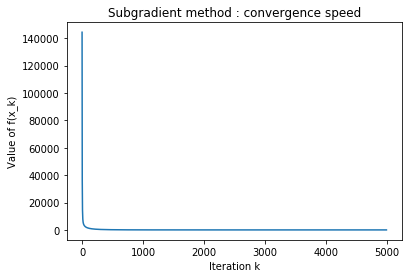

In [0]:
plt.plot(values_of_f)
plt.title("Subgradient method : convergence speed")
plt.xlabel("Iteration k")
plt.ylabel("Value of f(x_k)")
plt.show()

## 3. Méthode du sous-gradient stochastique

### 3.1

$f_i(v,a)=\frac{1}{2}\sum_jv_j^2 +cnmax(0,1-y_i(x_i^Tv+a))$
\begin{align*}
    \mathbb{E}[f_i(v,a)]&=\frac{1}{n} \sum_i f_i(v,a)\\
    &=\frac{1}{n}\sum_i(\frac{1}{2}\sum_jv_j^2 + cnmax(0,1-y_i(x_i^Tv+a)))\\
    &=\frac{1}{2}\sum_jv_j^2 + \sum_imax(0,1-y_i(x_i^Tv+a))\\
    &=f(v,a)\\
\end{align*}

### 3.2

We have that $f_i=N+cnh\circ M_i$ Thus,

$\partial f_i(v,a)=\partial N(v,a) + cnM_i^T\partial h(M_i(v,a))$

With $M_i=(y_ix_i^T\quad y_i)$.

Thus, 

$\partial f_i=\left(
\begin{array}{c}
v+cny_ix_i\partial h(y_i(x_i^Tv+a))\\
cny_i\partial h(y_i(x_i^Tv+a))\\
\end{array}
\right)$

### 3.3

In [0]:
def dronde_f_i(v, a, i, c=1):
    k = dronde_h(y[i]*(X[i,:].T.dot(v) + a))
    h = v + c*n*k*y[i]*X[i,:]
    output = np.concatenate((h, np.array([k*c*n*y[i]])), axis=0)
    return output

values_of_f_2 = []
values_of_k = []

def stochastic_subgradient(f, df, v0, a0, n_=100000, store=True):
    x = np.concatenate((v0, np.array([a0])))
    for k in range(n_):
        gamma = 1/(k+1)
        i = int(np.random.uniform(1, n))
        x = x - gamma*df(x[:-1], x[-1], i)
        if store and k>1 and k%100==0: 
            values_of_f_2.append(func_f(x[:m], x[m]))
            values_of_k.append(k)
    return x

result = stochastic_subgradient(func_f, dronde_f_i, np.zeros(m), 0)
print(result)
print('Final value of f :', func_f(result[:m], result[m]))

[ 2.34078471e-01 -4.27994186e-04  2.29736616e-01  2.92769841e-01
  2.03294119e-02 -5.77840875e-01  7.46081077e-01  8.57132513e-01
  1.77220078e-02 -2.96467123e-01  8.81062355e-01 -3.31720813e-01
  2.93954137e-01  9.89044009e-01  3.23962675e-01 -3.89911942e-01
 -4.33370890e-01  5.13160860e-01 -1.74164056e-01 -7.67649135e-01
  7.50657375e-01  1.05555984e+00  5.08279722e-01  9.25266664e-01
  4.95639102e-01 -2.29171021e-01  8.67158843e-01  2.23140090e-01
  5.84804120e-01  6.61805883e-01 -4.52739714e-02]
Final value of f : 28.571508913634


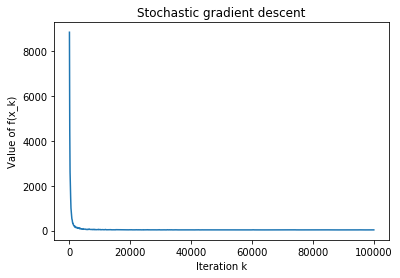

In [0]:
plt.plot(values_of_k, values_of_f_2)
plt.title("Stochastic gradient descent")
plt.xlabel("Iteration k")
plt.ylabel("Value of f(x_k)")
plt.show()

## 4. Méthode du lagrangien augmenté

### 4.1

Let $f(x)=\frac{1}{2}\sum_jv_j^2 + c\sum_i\xi_i$ Such that $\xi_i\geq 0, \xi_i\geq 1-y_i(x_i^Tv+a)) $

With $x=(a,v,\xi)$

$L(x,\phi)=f(x)+\sum_i\phi_i(max(0,1-y_i(x_i^Tv+a))-\xi_i)-\iota_{\mathbb{R}_+^n}(\phi)$

### 4.2

$g(x,\phi)=\frac{-1}{2\rho}\phi^2 + \frac{\rho}{2} (max(0,x+\rho^{-1}\phi))^2$

$
\begin{aligned}
\nabla_xg(x,\phi)&=\rho
  \left\{
      \begin{aligned}
        x+\rho^{-1}\phi\quad \text{if}\quad x+\rho^{-1}\phi\geq0\\
        0 \quad\text{else}\\
      \end{aligned}
    \right.\\
    &=\rho \mathrm{max}(0,x+\rho^-1\phi)
\end{aligned}
$
$
\begin{aligned}
\nabla_\phi g(x,\phi)&=
  \left\{
      \begin{aligned}
        -\frac{\phi}{\rho}+x+\frac{\phi}{\rho}\quad \text{if}\quad  x+\rho^{-1}\phi\geq0\\
        -\frac{\phi}{\rho} \quad\text{else}\\
      \end{aligned}
    \right.\\
    &=\left\{
      \begin{aligned}
        x\quad \text{if}\quad  x\geq-\frac{\phi}{\rho}\\
        -\frac{\phi}{\rho} \quad\text{else}\\
      \end{aligned}
    \right.\\
    &=\mathrm{max}(x,-\frac{\phi}{\rho})
\end{aligned}$

### 4.3

$\nabla_xg(x,\phi)$ increases with respect to x, which shows that g is convex with respect to x.
On the other hand,$\nabla_\phi(x,\phi)$ decreses with respect to $\phi$, thus, g is concav with respect to $\phi$. 

### 4.4

For the gradient algorithm, we compute the gradient of $L$ with respect to $v, a, \xi$.

We apply the chain rule and use question 4.2 to get the followings
$\nabla_vL=v-\sum_iy_ix_i\rho max(0,-\xi_i+1-y_i(x_i^Tv+a)+\frac{\psi_i}{\rho}) $

$\nabla_aL=\sum_i-y_i\rho max(0,-\xi_i+1-y_i(x_i^Tv+a)+\frac{\psi_i}{\rho})$

$\nabla_{\xi}L=c\mathbb{1}_n+\left(
\begin{array}{c}
-\rho max(0,-\xi_i+\frac{\phi_i}{\rho})\\
...\\
\end{array}
\right) +\left(
\begin{array}{c}
-\rho max(0,-\xi_i+1-y_i(x_i^Tv+a)+\frac{\psi_i}{\rho})\\
...\\
\end{array}
\right) $

$\nabla_{\phi}L=\left(
\begin{array}{c}
max(-\frac{\phi_i}{\rho},-\xi_i)\\
...\\
\end{array}
\right)$

$\nabla_{\psi}L=\left(
\begin{array}{c}
max(-\frac{\psi_i}{\rho},-\xi_i+1-y_i(x_i^Tv+a))\\
...\\
\end{array}
\right)$

In [0]:
def grad_g_in_x(x, phi, ro=2):
    #∇xg(x,φ) = ρmax(0,x+φρ)
    return ro*np.maximum(np.zeros(x.shape), x+phi/ro)
    
def grad_g_in_phi(x, phi, ro=2):
    #∇φg(x,φ) = max(−φρ,x)
    return np.maximum(-phi/ro, x)

def grad_g(x, phi, ro=2):
    return np.concatenate((grad_g_in_x(x, phi, ro), grad_g_in_phi(x, phi, ro)))

def func_g(x, phi, ro=2):
    return -0.5*phi**2 + (ro/2)*max(0, x + phi/ro)**2

def lagrangian(u, phi, psi, c=1, ro=2):
    v, a, ksi = infer_vaksi(u)
    h1 = np.zeros(m)
    h2 = np.zeros(m)
    for i in range(m):
        shortcut = -ksi[i] + 1 - y[i]*(X[i,:].T.dot(v) + a)
        h1[i] = func_g(-ksi[i], phi[i])
        h2[i] = func_g(shortcut, psi[i])
    return .5*np.linalg.norm(v)**2 + c*np.sum(ksi) + np.sum(h1) + np.sum(h2)

def infer_vaksi(u):
    if type(u) == np.ndarray:
        v = u[:m]
        a = u[m]
        ksi = u[m+1:]
    elif type(u) == list:
        v = u[0]
        a = u[1]
        ksi = u[2]
    return v, a, ksi

def grad_l_in_v_a_ksi(u, phi, psi, c=1, ro=2):
    """u is either a np.array with (v, a, ksi) concatenated
    either a list with the 3 params : [v, a, ksi] where each element is an np.array"""
    #Lρ(v,a,ξ,φ,ψ) =12‖v‖22+cn∑i=1ξi+n∑i=1g(−ξi,φi) +n∑i=1g(−ξi+ 1−yi(x>iv+a),ψi)
    v, a, ksi = infer_vaksi(u)
    # Compute gradient of ∑i=1 g(−ξi+ 1−yi(x>iv+a),ψi)
    
    # These complex matrix operations optimize the gradient's computation
    grad_in_v = v - np.sum((y*grad_g_in_x(-ksi + 1 - y*(X.dot(v) + a), phi)).reshape(-1,1).dot(np.ones((1,m)))*X, axis=0)
    grad_in_a = np.array([np.sum(- y*grad_g_in_x(-ksi + 1 - y*(X.dot(v) + a), phi))])
    grad_in_ksi = c - grad_g_in_x(-ksi, phi) - grad_g_in_x(-ksi + 1 - y*(X.dot(v) + a), phi)
    grad = np.concatenate((grad_in_v, grad_in_a, grad_in_ksi))
    return grad
 
def solve_grad_l(grad_l, phi0, psi0, epsilon=1, ro=2):
    #x_k = [v, a, ksi]
    x_k = np.zeros(m+1+n)
    gamma = 10e-4 # Empirically it works ok
    k = 0
    while np.linalg.norm(grad_l(x_k, phi0, psi0, ro=ro)) > epsilon:
        x_k = x_k - gamma*grad_l(x_k, phi0, psi0, ro=ro)
    return x_k

solve_grad_l(grad_l_in_v_a_ksi, np.zeros(n,), np.zeros(n,))

array([ 0.07862377,  0.0815796 ,  0.08059364,  0.15579354,  0.04785357,
       -0.66265703,  0.70080713,  0.91826364, -0.04654488, -0.17890808,
        0.88421051, -0.29620412,  0.29332295,  0.92223942,  0.28465922,
       -0.26373526, -0.33251756,  0.46431194, -0.19220873, -0.75368424,
        0.75795731,  1.05061544,  0.55804674,  0.91336905,  0.37203905,
       -0.21743201,  0.77101443,  0.31535076,  0.58975418,  0.6130205 ,
        0.0239215 , -0.48925149, -0.48925149, -0.48925149, -0.48925149,
       -0.48925149, -0.48925149, -0.48925149, -0.48925149, -0.48925149,
       -0.48925149, -0.48916135, -0.48925149, -0.48925149, -0.01763449,
       -0.48925149, -0.48925149, -0.48925149, -0.48925149, -0.48925149,
       -0.4498528 , -0.48925149, -0.48925149, -0.48925149, -0.48925149,
       -0.48925149, -0.48925149, -0.48925149, -0.48925149, -0.48925149,
       -0.48925149, -0.48925149, -0.48925149, -0.48925149, -0.48925149,
       -0.48925149, -0.48925149, -0.48925149, -0.48925149, -0.39

### 4.5

In [0]:
from scipy.optimize import check_grad

def grad_l_in_phi_psi(u, phi, psi, ro=2):
    """u is either a np.array with (v, a, ksi) concatenated
    either a list with the 3 params : [v, a, ksi] where each element is an np.array"""
    #Lρ(v,a,ξ,φ,ψ) =12‖v‖22+cn∑i=1ξi+n∑i=1g(−ξi,φi) +n∑i=1g(−ξi+ 1−yi(x>iv+a),ψi)
    v, a, ksi = infer_vaksi(u)
    
    grad_in_phi = grad_g_in_phi(- ksi, phi)
    grad_in_psi = grad_g_in_phi(-ksi + 1 - y*(X.dot(v) + a), psi)
    # Mathematically, we should do np.concatenate((grad_in_phi, grad_in_psi)) 
    # but here we won't because it's cumbersome for the algorithm
    return grad_in_phi, grad_in_psi



grad_l_in_phi_psi(np.random.random(m+1+n), np.ones(n,), np.ones(n,))



(array([-0.5       , -0.5       , -0.05405331, -0.5       , -0.23092748,
        -0.5       , -0.5       , -0.22615521, -0.32217648, -0.5       ,
        -0.28399924, -0.5       , -0.3732183 , -0.5       , -0.39900101,
        -0.43125092, -0.09447418, -0.06487222, -0.38787641, -0.5       ,
        -0.5       , -0.22654472, -0.25185076, -0.23045459, -0.5       ,
        -0.46381701, -0.29061303, -0.5       , -0.3393929 , -0.5       ,
        -0.00516373, -0.5       , -0.37483953, -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.37270165, -0.33042697, -0.09701524,
        -0.5       , -0.5       , -0.43725633, -0.25636234, -0.1940331 ,
        -0.5       , -0.47940826, -0.12544891, -0.5       , -0.26306134,
        -0.24041748, -0.11930675, -0.20929451, -0.30922197, -0.25174936,
        -0.30092337, -0.16911206, -0.5       , -0.10917039, -0.24206797,
        -0.39720017, -0.5       , -0.5       , -0.35077334, -0.14580874,
        -0.08647781, -0.5       , -0.36239123, -0.4

### 4.6

In [0]:
def func_f_1(u):
    v, a, ksi = infer_vaksi(u)
    return .5*np.sum(v**2) + np.sum(ksi)

def augmented_lagrangian(func_f, solve_grad_l, grad_l_in_v_a_ksi, grad_l_in_phi_psi, 
                         phi0=np.zeros(n), psi0=np.zeros(n), n=2000, ro=2):
    k = 0
    phi = phi0
    psi = psi0
    while k < n:
        k = k+1
        u = solve_grad_l(grad_l_in_v_a_ksi, phi, psi)
        #print(func_f_1(u))
        #print(func_f(u[:m], u[m]))
        grad_phi, grad_psi = grad_l_in_phi_psi(u, phi, psi)
        phi = phi + ro*grad_phi
        psi = psi + ro*grad_psi
    return u
        
augmented_lagrangian(func_f, solve_grad_l, grad_l_in_v_a_ksi, grad_l_in_phi_psi, n=2000)[:m+1]

In [0]:
# Here is the function value for a solution we found after 2000 iterations
print('Final value of f :', func_f(np.array([ 0.05174917,  0.07545425,  0.05527832,  0.14754281,  0.07196709,
       -0.68985781,  0.69142525,  0.92548095, -0.0602703 , -0.16372129,
        0.90625349, -0.2866303 ,  0.2832346 ,  0.93238764,  0.28763493,
       -0.26306783, -0.32564543,  0.44880844, -0.19270613, -0.75352012,
        0.77936071,  1.05160644,  0.57247223,  0.9321838 ,  0.3479023 ,
       -0.20592973,  0.75796568,  0.34854591,  0.59388106,  0.60411768]),
        0.04307116))


Final value of f : 27.641158123053206


## 5. Comparaison

### 5.1

- The subgradient method is satisfactory and trustful. Overall, it's the fastest and it finds a very good minimum.
- The stochastic gradient method takes way more iteration to converge. But each iteration requires less calculation and is performed quickly. Sometimes, however, it yields a much higher value than the subgradient method. 
- The augmented lagrangian requires more computation for each iteration, but converges super quickly iteration-wise. The minimum value is, however, stalls slightly higher than those of other techniques. 

Below are some benchmarks :

- subgradient : 5000 iterations
- stochastic subgradeint : 1 000 000 iterations
- augmented lagrangian : 5 iterations (same result as for 2000 above)

In [0]:
%%time
minimizer = subgradient_method(func_f, dronde_f, np.zeros(m), 0, n=5000, store=False)
print(func_f(minimizer[:-1], minimizer[-1]))

26.67549724027331
CPU times: user 359 ms, sys: 4.05 ms, total: 363 ms
Wall time: 183 ms


In [0]:
%%time
minimizer = stochastic_subgradient(func_f, dronde_f_i, np.zeros(m), 0, n_=int(1*1e6), store=False)
print(func_f(minimizer[:-1], minimizer[-1]))

26.63963629348864
CPU times: user 15.1 s, sys: 185 ms, total: 15.3 s
Wall time: 15 s


In [0]:
%%time
minimizer = augmented_lagrangian(func_f, solve_grad_l, grad_l_in_v_a_ksi, grad_l_in_phi_psi, n=5)
print(func_f(minimizer[:m], minimizer[m]))

27.641157917155258
CPU times: user 4.66 s, sys: 15.8 ms, total: 4.68 s
Wall time: 2.34 s
